## Handle gem files for downstream analysis

:::{note}
GEM is a tabular structure format specified for saving stereo-seq data, which generally contains columns of x, y, geneID, MIDCount and decodes the feature information captured by each DNB on the stereo-seq chip. Additional columns counld be included for DNB/feature annotation. A demo description can be found at   [stereopy site](https://stereopy.readthedocs.io/en/latest/Tutorials/IO.html#GEM). 
:::

In [1]:
import sys
sys.path.append('../../')

In [2]:
from spacipy import Gem

Read in example gem data, which holds mouse brain stereo-seq data from [here](https://www.stomics.tech/demoData).

In [3]:
gem = Gem.readin('../_static/data/example.gem.gz')

In [4]:
gem

,geneID,x,y,MIDCounts
0,Cr2,10059,14612,1
1,Cr2,6066,11227,3
2,Cr2,10521,11108,1
3,Cr2,8072,11782,3
4,Cr2,7891,16372,1
...,...,...,...,...
106663420,CAAA01147332.1,12756,17013,1
106663421,CAAA01147332.1,11907,12871,1
106663422,CAAA01147332.1,14707,4862,1
106663423,CAAA01147332.1,9787,5437,1


### preliminary understanding of your data

GEM saves spatial transcriptomics data, which can be easily understanding by seeing what it looks like.

None


[<Axes: >]

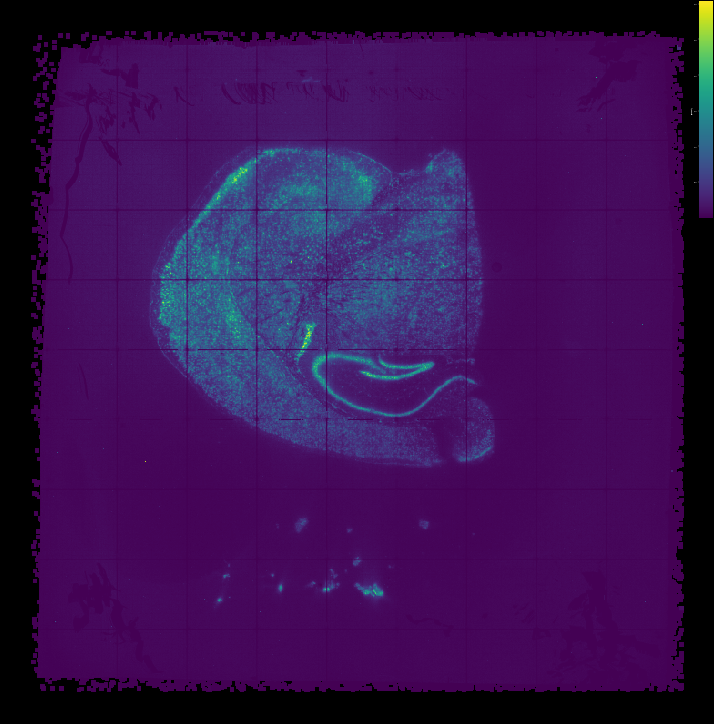

In [5]:
gem.plot(color='nCount', bin_size=20)

**here you may focus on two points:**
  1. whether the spatial distributuion of the data is well decoded
  2. how many features were captured in each square bin or DNB

### extract data where tissue covered

Not all DNBs on the stereo-seq chip were covered by the tissue. An effective way for deleting non-related data is to use a mask, which is often a two dimensional numpy ndarray with tissue regions labeled as non-zero integer (see [here](<https://numpy.org/doc/stable/reference/maskedarray.generic.html#what-is-a-masked-array>)). Once prepared a ready-to-use mask matrix, you can process as following:

In [6]:
import numpy as np
mask = np.loadtxt('../_static/data/example.transformed_mask.txt.gz')
mask.shape

(14451, 14248)

In [7]:
gem.img_shape

(14451, 14248)

In [8]:
gem = gem.mask(matrix=mask, return_offset=False, label_object=True)

now the gem data will be

None


[<Axes: >]

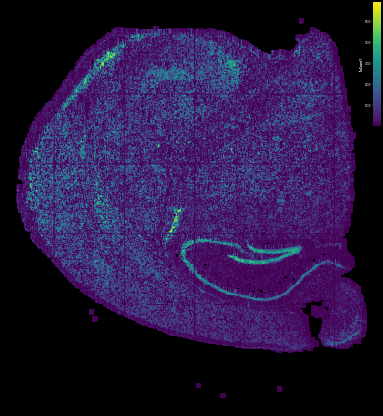

In [9]:
gem.plot(color='nCount', bin_size=20)

### aggregate the data into cell/bin unit

After getting the effective data set, the next step is to determine how to group the nanometer-resolution DNB array into a analysis-ready unit, here always in two way:
  1. group into square bin with equal width and height
  2. group into putative cells

#### 1. group into square bin

Square binning strategy do NOT consider any other informations like nucleus location and molecular homogeny. The only parameter in this step is *bin_size*, which specify how many DNBs in width and height should be grouped as a single bin unit. People can change this value based on the physical area of each bin and the captured features in each bin unit. 

In [10]:
binning_gem = gem.binning(bin_size=20)
binning_gem

,geneID,x,y,label,MIDCounts
0,0610005C13Rik,5780,12540,16200,3
1,0610005C13Rik,5960,12760,14612,1
2,0610005C13Rik,5980,10700,28985,3
3,0610005C13Rik,6100,10240,32093,1
4,0610005C13Rik,6140,11420,23757,2
...,...,...,...,...,...
31798037,mt-Nd6,12880,8940,37309,2
31798038,mt-Nd6,12880,8960,37122,2
31798039,mt-Nd6,12880,9140,36185,1
31798040,mt-Nd6,12900,8640,39087,2


#### 2. group into putative cells

Currently stereo-seq comprehend ssDNA stainning protocal, which stains the nucleus of cells on the same section. With the location of cell nucleus decoded, labeled with numpy mask file. And in the previous `gem.mask` process, we have labeled each DNB with their cell IDs by setting `label_object=True`.

In [11]:
gem


,geneID,x,y,MIDCounts,label
0,Cr2,8072,11782,3,20638
1,Cr2,7832,10872,1,27089
2,Cr2,6608,10674,1,28950
3,Cr2,9790,14297,2,3574
4,Cr2,6594,12299,2,17562
...,...,...,...,...,...
37759281,CAAA01147332.1,12231,11534,1,20817
37759282,CAAA01147332.1,10776,12505,2,14553
37759283,CAAA01147332.1,9810,10370,1,29920
37759284,CAAA01147332.1,10653,12974,1,11713


with cell ID labels, the gem file could be aggregated into cell-gene matrix as AnnData object

In [13]:
adata = gem.to_anndata()
adata

AnnData object with n_obs × n_vars = 41502 × 25288

the anndata object can be write into h5ad file and further used in clustering analysis

In [15]:
adata.write('../_static/data/example.h5ad')